In [1]:
import numpy as np
import mosek
import cvxpy as cp
import matplotlib.pyplot as plt

In [8]:
def disc_linear_system(A, B, delta_t):
    '''
    Discrete a linear system with implicit Euler
    x[k+1] = (I - delta_t * A)^{-1} @ x[k] + (I - delta_t * A)^{-1} @ (delta_t * B) @ u[k]
    Returns:
        Ak
        Bk
    '''
    Nx = np.shape(A)[0]
    Ix = np.identity(Nx)

    Ak = np.linalg.inv(Ix - delta_t * A)
    Bk = np.linalg.inv(Ix - delta_t * A) @ (delta_t * B)

    
    def disc_linear_fn(x, u):
        x_next = Ak @ x + Bk @ u
        
        return x_next
    
    
    return disc_linear_fn

In [92]:
# Collect data as initial condition
def data_generation(sys, nx, nu, N, state_init = None, input_seq = None):
    # N is the length of collected data
    # Modify this for measurement functions (y = Cx)
    if input_seq is None:
        input_seq = np.random.rand(nu, N) *10
    N_it = np.shape(input_seq)[1] # Number of iteration
    if state_init is None:
        state_init = np.random.rand(nx,1) *10
    state_seq = state_init
    xk = state_init
    for _ in range(N_it):
        uk = input_seq[:,_].reshape(-1,nu)
        state_next = sys(xk, uk)
        state_seq = np.concatenate((state_seq, state_next),axis=1)
        xk = state_next
    # Remark: the length of state_seq is larger than the input_seq by one.
    return state_seq, input_seq

In [93]:
# Construct Hankel matrix
def Hankel(sequence, L):
    n, T = np.shape(sequence)
    print(n,T)
    Hankel_matrix = np.empty((n * L, 0), dtype = float)
    for _ in range(T-L+1):
        Hankel_matrix = np.concatenate((Hankel_matrix, sequence[: , _ : _+L ].reshape(-1,1, order = 'F')),axis = 1)
    return Hankel_matrix

In [134]:
# Formulate optimization problem
def define_opt(nu, ny, Q, R, U_Hankel, Y_Hankel, L, n, u_ns, y_ns, r = None, uub = None, ulb = None, yub = None, ylb = None):
    # Let the reference traj r be a list setpoint for input and output. To be modified, if tracking traj required.
    
    u_decision = cp.Variable(((L+n)*nu,1))
    y_decision = cp.Variable(((L+n)*ny,1))
    
    
    alpha = cp.Variable((T-(L+n)+1,1))
    
    u_init_para = cp.Parameter((n * nu, 1))
    y_init_para = cp.Parameter((n * ny, 1))
    
    
    loss_func = 0
    for _ in range(L):
        loss_func += cp.quad_form(y_decision[ ( n + _ ) * ny : ( n + _ + 1 ) * ny ,:] - np.array(r[:ny]).reshape(-1,1), Q)
        loss_func += cp.quad_form(u_decision[ ( n + _ ) * nu : ( n + _ + 1 ) * nu ,:] - np.array(r[ny:]).reshape(-1,1), R)

    obj = cp.Minimize(loss_func)
    # Define constraints
    constraint = []
    
    constraint += [ u_decision == U_Hankel @ alpha ]
    constraint += [ y_decision == Y_Hankel @ alpha ]
    constraint += [ u_decision[: n * nu] == u_init_para ]
    constraint += [ y_decision[: n * ny] == y_init_para ]
    constraint += [ u_decision[- n * nu :] == u_ns ]
    constraint += [ y_decision[- n * ny :] == y_ns ]
    
    if uub is not None:
        for _ in range(L):
            constraint += [u_decision[ ( n + _ ) * nu : ( n + _ + 1 ) * nu, : ] <= uub]
    
    if ulb is not None:
        for _ in range(L):
            constraint += [u_decision[ ( n + _ ) * nu : ( n + _ + 1 ) * nu, : ] >= ulb]

    if yub is not None:
        for _ in range(L):
            constraint += [y_decision[ ( n + _ ) * ny : ( n + _ + 1 ) * ny ,:] <= yub]
            
    if ylb is not None:
        for _ in range(L):
            constraint += [y_decision[ ( n + _ ) * ny : ( n + _ + 1 ) * ny ,:] >= ylb]
            
    prob = cp.Problem(obj,constraint)
    
    return prob, alpha, u_init_para, y_init_para

In [137]:
# Simulation
def sim(opt_prob, sys, C, N_sim, delta_t, alpha, n, nu, ny, u_init, y_init, u_init_para, y_init_para, x_init, input_Hankel, r = None):
    # Generally, u_ini and y_ini are sequences, and x_init is the corresponding initial state of the last element in sequences
    t0 = 0
    xk = x_init
    uk = 0
    t = t0
    h = delta_t

    x_list = []
    x_list += xk.flatten().tolist()
    u_list = []

    # N_sample_max
    for i in range(N_sim):
        u_init_para.value = u_init
        y_init_para.value = y_init
        prob.solve(solver=cp.MOSEK)
        print(xk,uk)
        uk = (input_Hankel @ alpha.value)[nu * n : nu * (n+1),:]
        u_list += uk.flatten().tolist()
        x_kp1 = sys(xk, uk)
        xk = x_kp1
        yk = C @ xk
        u_init = np.concatenate(( u_ini[nu:,:], uk ), axis = 0 )
        y_init = np.concatenate(( y_ini[ny:,:], yk ), axis = 0 )
        x_list += xk.flatten().tolist()

    return x_list, u_list

First case study, Mass spring system

1. larger prediction horizon required than DeePC; otherwise not stable.
2. Higher cost, since terminal constraints imposed.
3. Both methods fails with random input and output sequences in small value -> multiply 10

In [138]:
a = np.array([[1],[1]])
b = np.array([[2],[2]])
np.concatenate((a, b), axis=1)

array([[1, 2],
       [1, 2]])

In [149]:
m = 2  # [kg]
k1 = 3  # [N/m]
k2 = 2  # [N/m]

A = np.array([[0, 1], [-k2 / m, -k1 / m]])
B = np.array([[0], [1 / m]])


Q = np.diag([10, 1])
R = np.diag([1])


dt = 0.1
disc_sys_fn = disc_linear_system(A,B, dt)
nx = 2
nu = 1


n = 1
L = 10
T = (nu + 1) * (n + L + nx) - 1
state_seq, input_seq = data_generation(disc_sys_fn, nx, nu, T)

state_init = np.array([[5],[0]])
y_init_seq, u_init_seq = data_generation(disc_sys_fn, nx, nu, n, state_init = state_ini)

In [150]:
state_Hankel = Hankel(state_seq[:,:-1], L+n)
input_Hankel = Hankel(input_seq, L+n)

2 25
1 25


In [151]:
y_init = y_init_seq[:,:-1].reshape(-1,1, order = 'F')
u_init = u_init_seq.reshape(-1,1, order = 'F')

u_ns = np.array([[0]])  # terminal equalibrium constraints
y_ns = np.array([[0],[0]])

In [152]:
r = [0,0,0]

In [153]:
prob, alpha, u_init_para, y_init_para = define_opt(nu, nx, Q, R, input_Hankel, state_Hankel, L, n, u_ns, y_ns, r = r)

In [154]:
u_init

array([[2.99874805]])

In [155]:
y_init

array([[5.],
       [0.]])

In [156]:
u_init_para.value = u_init
# u_init_para.value = np.array([[6.19632452]])
y_init_para.value = y_init
prob.solve(solver=cp.MOSEK,verbose=True)
input_Hankel @ alpha.value 



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 68              
  Cones                  : 20              
  Scalar variables       : 109             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 68              
  Cones                  : 20              
  Scalar variables       : 109             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 33
Optimizer  - Cones                  : 21
Optimizer  - Scalar variables

array([[  2.99874805],
       [-66.46060235],
       [-57.58703869],
       [-47.06799731],
       [-34.67403793],
       [-20.15087162],
       [ -3.22188225],
       [ 16.40917456],
       [ 39.05441512],
       [ 65.03697676],
       [  0.        ]])

In [157]:
C = np.identity(nx)
N_sim = 100
ny = nx
x_init = y_ini[-(nx):,:]
x_list, u_list = sim(prob, disc_sys_fn, C, N_sim, dt, alpha, n, nu, ny, u_init, y_init, u_init_para, y_init_para, x_init, input_Hankel)

[[5.]
 [0.]] 0
[[ 4.67042844]
 [-3.29571562]] [[-66.46060235]]
[[ 4.2555789 ]
 [-4.14849538]] [[-20.98992354]]
[[ 3.75700212]
 [-4.98576785]] [[-24.18874867]]
[[ 3.24485001]
 [-5.12152101]] [[-11.58992636]]
[[ 2.74140111]
 [-5.03448906]] [[-7.88002598]]
[[ 2.2711015 ]
 [-4.70299613]] [[-2.9369266]]
[[ 1.84484644]
 [-4.26255053]] [[-0.28904671]]
[[ 1.46931072]
 [-3.75535724]] [[1.81641546]]
[[ 1.14590743]
 [-3.2340329 ]] [[3.01620288]]
[[ 0.87327489]
 [-2.72632538]] [[3.7217241]]
[[ 0.64793858]
 [-2.25336307]] [[3.99503404]]
[[ 0.46529829]
 [-1.82640297]] [[3.99058969]]
[[ 0.320178  ]
 [-1.45120281]] [[3.79075077]]
[[ 0.207283  ]
 [-1.12895009]] [[3.4727702]]
[[ 0.12149336]
 [-0.85789635]] [[3.09037256]]
[[ 0.05805601]
 [-0.63437348]] [[2.6834488]]
[[ 0.01269503]
 [-0.45360982]] [[2.27983382]]
[[-0.0183367 ]
 [-0.31031732]] [[1.89822463]]
[[-0.03824955]
 [-0.19912846]] [[1.54989288]]
[[-0.04973721]
 [-0.11487667]] [[1.24093133]]
[[-0.05501666]
 [-0.05279444]] [[0.97322788]]
[[-0.0558765

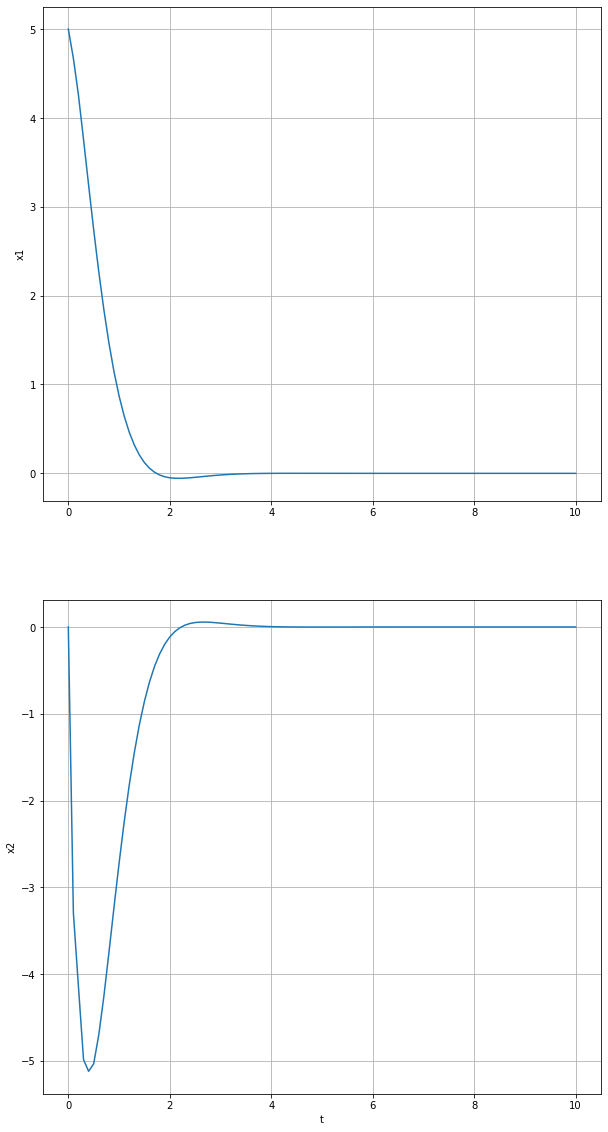

In [158]:
delta_t = dt
n = nx

x_traj = x_list

Nt = np.shape(x_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    x_traj_temp = x_traj[i::n]
    plt.plot(t_plot, x_traj_temp)
    plt.ylabel('x' + str(i + 1))

plt.xlabel('t')
plt.show()

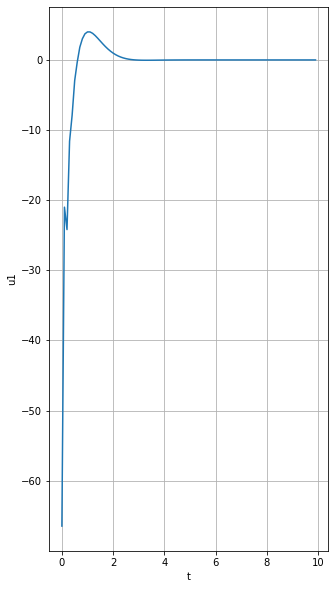

In [159]:
delta_t = dt
n = nu

u_traj = u_list

Nt = np.shape(u_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(5, 10))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    u_traj_temp = u_traj[i::n]
    plt.plot(t_plot, u_traj_temp)
    plt.ylabel('u' + str(i + 1))

plt.xlabel('t')
plt.show()

Second case study: four tank system (case study in their paper)

It is the linear version of the nonlinear four tank system (ref: Nonlinear Model Predictive Control of a Four Tank System: An Experimental Stability Study).

$\begin{aligned} \dot{x}_{1} &=-\frac{a_{1}}{A_{1}} \sqrt{2 g x_{1}}+\frac{a_{3}}{A_{1}} \sqrt{2 g x_{3}}+\frac{\gamma_{1}}{A_{1}} u_{1} \\ \dot{x}_{2} &=-\frac{a_{2}}{A_{2}} \sqrt{2 g x_{2}}+\frac{a_{4}}{A_{2}} \sqrt{2 g x_{4}}+\frac{\gamma_{2}}{A_{2}} u_{2} \\ \dot{x}_{3} &=-\frac{a_{3}}{A_{3}} \sqrt{2 g x_{3}}+\frac{\left(1-\gamma_{2}\right)}{A_{3}} u_{2} \\ \dot{x}_{4} &=-\frac{a_{4}}{A_{4}} \sqrt{2 g x_{4}}+\frac{\left(1-\gamma_{1}\right)}{A_{4}} u_{1} \end{aligned}$

Linearized version (ref: Data-Driven Model Predictive Control with Stability and Robustness Guarantees)

$ x_{k+1} =\left[\begin{array}{cccc}0.921 & 0 & 0.041 & 0 \\ 0 & 0.918 & 0 & 0.033 \\ 0 & 0 & 0.924 & 0 \\ 0 & 0 & 0 & 0.937\end{array}\right] x_{k} +\left[\begin{array}{cc}0.017 & 0.001 \\ 0.001 & 0.023 \\ 0 & 0.061 \\ 0.072 & 0\end{array}\right] u_{k}$

$y_{k}=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0\end{array}\right] x_{k}$

set point: $\left(u^{s}, y^{s}\right)=\left(\left[\begin{array}{l}1 \\ 1\end{array}\right],\left[\begin{array}{l}0.65 \\ 0.77\end{array}\right]\right)$